In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
g = 9.81

def ddt(mu, state, t):
    #some of these have been complicated with newton's 2nd law in polar coord form
    rdotdot = (g*(-mu+np.cos(state[2])) + state[0]*state[3]**2) / (1+mu)
    thetadotdot = (-g*np.sin(state[2])-2*state[1]*state[3])/state[0]
    return np.array([state[1],rdotdot,state[3],thetadotdot]) #r, rdot, theta, thetadot

def rk4(mu, state, t, dt):
    f0 = ddt(mu, state, t)
    f1 = ddt(mu, state+f0*(dt/2), t + dt/2)
    f2 = ddt(mu, state+f1*(dt/2), t + dt/2)
    f3 = ddt(mu, state+f2*(dt), t + dt)
    s_next = state + (f0 + 2 * f1 + 2 * f2 + f3) * dt / 6
    return s_next

In [95]:
def SAM(mu, init_state, t):
    states=[init_state] #this captures all necessary params: r, rdot, theta, thetadot
    times = [0]
    dt = 0.005
    threshold = 0.005

    for i in range(int(t/dt)):
        if(states[-1][0] < threshold * init_state[0]):
            print("Possible singularity. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        if(states[-1][0] > init_state[0]/threshold):
            print("Possible unbounded solution. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        states.append(rk4(mu, states[-1], times[-1], dt))
        times.append(times[-1] + dt)
        
    
    # transform and transpose
    states = np.array(states)
    states = states.transpose()

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location("S")
    ax.plot(states[2], states[0], color='r', linewidth=1)
    plt.title("$\mu = %.3f$, $r_0 = %.3f$, $\\dot{r_0} = %.3f$, $\\theta_0 = %.3f$, $\\dot{\\theta_0} = %.3f$" % (mu, init_state[0], init_state[1], init_state[2], init_state[3]))
    ax.grid(True)
    

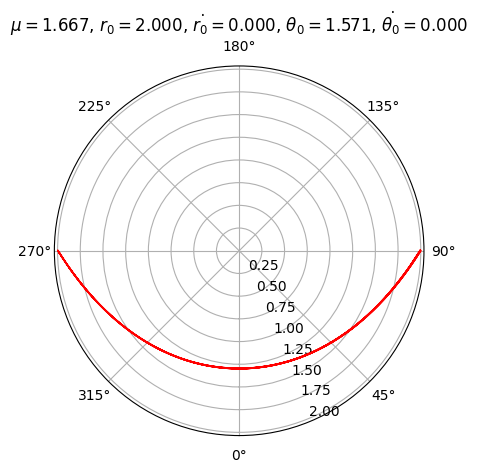

In [62]:
SAM(1.667, np.array([2,0,np.pi/2,0]), 10) #known periodic orbit

Possible singularity. Stopping simulation. (r=0.009)


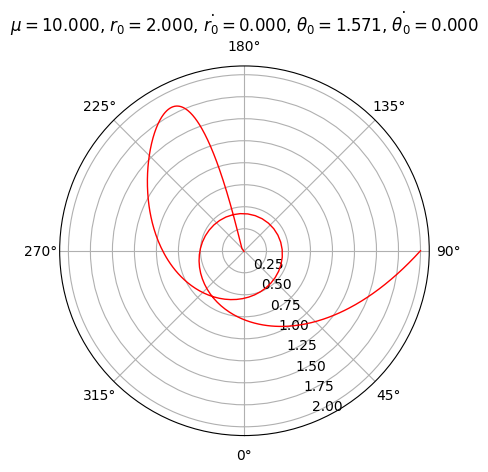

In [98]:
SAM(10, np.array([2,0,np.pi/2,0]), 10) #known singular orbit

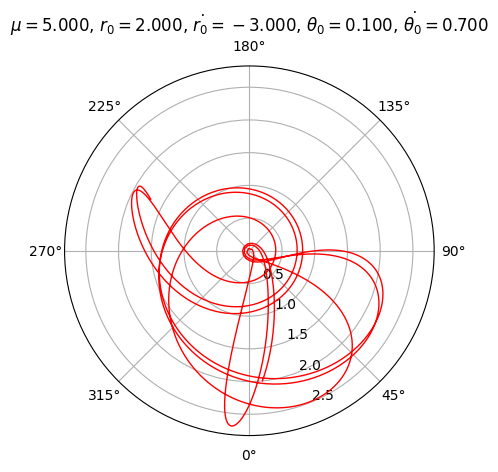

In [109]:
SAM(5, np.array([2,-3,0.1,0.7]), 10) #some initial velocity